In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

## Supervised learning on mice phenotype data

Predicting diet from differential expression data was easy with SVMs. It was very neat and regular data, no cells were missing, all values were in a similar range, etc. We will now use a slightly uglier dataset: the phenotype tables from days 3/4.

You may remember that each of those sheets had one row per strain, and two separate columns for each measurement taken under the two dietary conditions. We have transformed those sheets such that 1) all of them are contained in a single table, 2) each strain gets two rows, one for phenotype measurements under CD and one for HFD diet. We will use the `diet` column as our target.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import sklearn.model_selection as sm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics as sme
from sklearn.model_selection import cross_val_predict

In [3]:
pheno = pd.read_csv('files/phenotype_cd_hfd.csv', index_col=0)

print(pheno.shape)

target = pheno['diet'].replace('CD', 0).replace('HFD', 1)

(113, 181)


### 1.1 Get rid of columns with missing values

Since most ML algorithms can't deal with NaN values, we will first restrict ourselves to those features that are available for every sample.
Identify these columns and put `pheno.loc[:, good_columns]` into the variable `data`.

Also, drop the columns `diet` and `strain` from the data table, since we don't want to use them for prediction.

In [4]:
data = pheno.dropna(axis=1)
data = data.drop(['strain', 'diet'], axis=1)

### 1.2 Use an SVM for your predictions
Try the RBF kernel for a change. First, fit and score using the entire dataset, and print out the accuracy.
Do a proper evaluation using 3-fold cross-validation, and print those scores as well. How did it go?

In [18]:
# The RBF kernel is the default
clf = SVC(random_state=0)
clf.fit(data, target)
clf.predict(data)
clf.score(data, target)

1.0

In [20]:
sm.cross_val_score(clf, data, target, cv = sm.StratifiedKFold(3, shuffle=True)).mean()

0.4954954954954955

0.4954954954954955 for the 3-fold accuracy. This is even slightly worse than a random assignment.

### 1.3 Use a linear kernel to get the same two values
Was it better or worse than with the RBF? Why?

In [19]:
clf_linear = SVC(kernel ='linear', random_state=0, probability=True)
clf_linear.fit(data, target)
clf_linear.predict(data)
clf_linear.score(data, target)

0.9823008849557522

In [21]:
sm.cross_val_score(clf_linear, data, target, cv = sm.StratifiedKFold(3, shuffle=True)).mean()

0.8591749644381222

The linear kernel performs way better than the rbf kernel. 

### 1.4 Standardize the data
Look at the value ranges of each feature. Standardize them, such that they all have zero mean and 1 standard deviation. Either by simply subtracting the means and dividing by the standard deviations, or using the `sklearn.preprocessing.StandardScaler` class.

Display the cross-validated scores using an RBF and a linear SVM.

In [23]:
scaler = StandardScaler()
scaler.fit(data)

data_standardized = scaler.fit_transform(data)


In [8]:
clf.fit(data_standardized, target)

sm.cross_val_score(clf, data_standardized, target, cv = sm.StratifiedKFold(3, shuffle=True)).mean()

0.9291133238501659

In [9]:
clf_linear.fit(data_standardized, target)

sm.cross_val_score(clf_linear, data_standardized, target, cv = sm.StratifiedKFold(3, shuffle=True)).mean()

0.8852536747273589

Some features with a high range in variance bias the svm into looking just for those certain feature, finding patterns there and not paying that much attention to the remaining. 
By standartizing the dataset, all features were roughly equal important, and the SVM is able to perform a better seperation. 

### 1.4.2 Optional: Standardize the data fold-by-fold

When we standardized the entire dataset in one go, we were cheating a bit. We did not keep the training and test data fully independent. For a truly honest evaluation, we should derive the standardization parameters from the training data only, and apply the same transformation to the test data separately.

If you standardize manually, use the training set means and std's for the transformation of both the training and the test data. If you use `StandardScaler`, use `fit_transform` for the training data and `transform` only for the training data.

Did it influence the accuracy?

In [67]:
cv = sm.StratifiedKFold(3, shuffle=True)

sensitivity = 0
specificity = 0
precision = 0

for training, test in cv.split(data, target):
    
    data_train = data.iloc[training]
    data_train_stand = scaler.fit_transform(data_train)
    target_train = target.iloc[training]
    
    
    data_test = data.iloc[test]
    data_test_stand = scaler.transform(data_test)

    target_test = target.iloc[test]
    
    clf_linear.fit(data_train_stand, target_train)
    #print(clf_linear.score(data_test, target_test))
    
    y_pred = clf_linear.predict(data_test_stand)
    y_true = target_test

    conf_matrix = confusion_matrix(y_true, y_pred)
    
    tp = conf_matrix[1][1]
    fp = conf_matrix[0][1]
    tn = conf_matrix[0][0]
    fn = conf_matrix[1][0]

    sensitivity += tp/(tp+fn)
    specificity += tn/(tn+fp)
    precision += tp/(tp + fp)
 
print('Sensitivity: ' + str(sensitivity/3))
print('Specificity: ' + str(specificity/3))
print('Precision: ' + str(precision/3))

Sensitivity: 0.841130604288499
Specificity: 0.8421052631578947
Precision: 0.860411899313501


In [11]:
#OR
predictions = sm.cross_val_predict(clf_linear, data, target, cv = sm.StratifiedKFold(3, shuffle=True))

sme.classification_report(target, predictions)

'             precision    recall  f1-score   support\n\n          0       0.91      0.88      0.89        57\n          1       0.88      0.91      0.89        56\n\navg / total       0.89      0.89      0.89       113\n'

The fold-by-fold standardization make the results worse again. This is actually more legit, by standartizing the whole dataset we already take the data which is later used for testing in account. In a "real" case the SVM can't know about the data is will face, so the fold-by-fold method is the way to go if you don't want to cheat on your results.

### 1.5: Sensitivity, specificity, precision...
In some cases, the accuracy of a prediction is secondary to other quality measures, such as sensitivity or specificity. For example, HIV tests are optimized for sensitivity at the expense of accuracy, ensuring that very few HIV-positive individuals test negative on an HIV test. This results in an HIV-scare for a lot of HIV-negative individuals each year (as higher sensitivity always implies a higher false positive rate) but in exchange no case of HIV goes undetected on a test.

We can tune most ML models similarly, and sacrifice accuracy for higher sensitivity or specificity. But first, simply report the sensitivity of your linear SVM for both classes. You will find tools in `sklearn` that help you calculate this value.

In [ ]:
# This is already implemented in the cell above

### 1.5.2 Make your SVM 95+% sensitive for HFD
Find a parameter that helps you increase your sensitivity for mice on an HFD diet.

In [33]:
#Make use of the class_weight parameter. HFD gets 100% class weight -> every point is assigned to it -> no point is missed 
# -> every point is captured  = 100% sensitive for HFD

clf_sensitive = SVC(C=3.0, kernel = 'linear', probability=True, tol=3)

clf_sensitive.fit(data, target)

prediction = cross_val_predict(clf_sensitive, data, target, cv = cv)

print(sme.classification_report(target, prediction))

conf_matrix = confusion_matrix(target, prediction)
    
tp = conf_matrix[1][1]
fp = conf_matrix[0][1]
tn = conf_matrix[0][0]
fn = conf_matrix[1][0]

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp + fp)

print('Sensitivity: '+ str(sensitivity))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        57
          1       0.50      1.00      0.66        56

avg / total       0.25      0.50      0.33       113

Sensitivity: 1.0


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 1.6 ROC curves
You might be interested in your model's relationship between its accuracy and sensitivity, or a more commonly used pair of quality measures: false positive rate vs. sensitivity (aka true positive rate). This is what ROC (receiver operating characteristic) curves display: the trade-off between these two qualities.

Most classification ML methods, despite their categorical output, use continuous internal variables for their predictions, and their final decision is a simple thresholding of this continuous variable. For example, in the case of SVMs, this variable is the data point's signed distance to the separating plane: positive values are assigned to one class, negative values to the other class. Values close to zero (= close to the boundary) are harder to place in either class, and it's down to the arbitrary threshold how they end up being predicted.

You can create a ROC curve by testing how the choice of threshold affects false positive rate and sensitivity. Needless to say, sklearn helps you create such plots. All you need to do is extract the SVM's continuous predictive variables, pass it to the appropriate function with the true labels, and plot the results.

In [50]:
predictions = sm.cross_val_predict(clf_linear, data, target, cv = sm.StratifiedKFold(3, shuffle=True), method='predict_proba')


In [14]:
values = []
for i in range(len(predictions)):
    values.append(predictions[i][1])

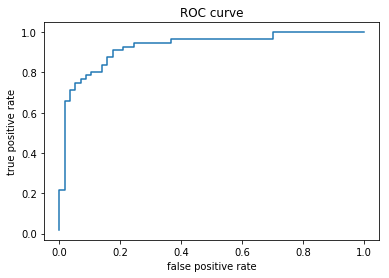

In [48]:
fpr, tpr, thresholds = sme.roc_curve(target, values)

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve')
roc_curve = plt.plot(fpr, tpr)


### 1.7 Find the threshold for the desired sensitivity / FPR tradeoff
In 1.5.2 you increased sensitivity for HFD (label 1) by telling the SVM to use a higher weight for that class. Since then, you have learned that you could have also used the SVM's continuous predictive variables, and threshold them to your own liking, instead of leaving it to the SVM's default (0 for decision_function and 0.5 for predict_proba).

Your task is to find the threshold value that would suit your purpose (i.e. 95% sensitivity). Remember, the roc_curve function returned three vectors: the ROC plot's FPR values, sensitivity values and the threshold that corresponded to them.

Hint: iterate over the sensitivity and threshold values together, and report the first threshold where sensitivity exceeds 0.95. You can iterate over two lists together using Python's zip function.

In [45]:
for sensitivity, threshold in zip(tpr, thresholds):
    if sensitivity > 0.95:
        print (threshold)
        break

0.2566586472212105
